In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import bartlett
import seaborn as sns
import scipy.stats as stats
from tqdm import tqdm
# import shap
#Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [6]:
df1 = pd.read_csv('./집단 분리/월별/analysis/7_analysis.csv')
df2 = pd.read_csv('./집단 분리/월별/analysis/8_analysis.csv')
df = pd.concat([df1,df2],axis=0)

In [7]:
df['id'] = df['device_id_deidentification'].str[8:]
df['create_dt'] = pd.to_datetime(df['create_dt'])

In [8]:
# 필요없는 변수 제거
df.pop('airstate.miscfuncstate.uvnano')
df.pop('airstate.miscfuncstate.filtercleanauto')
df.pop('pm1')
df.pop('pm2')
df.pop('pm10')

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
3331639    0.0
3331640    0.0
3331641    0.0
3331642    0.0
3331643    0.0
Name: pm10, Length: 6963608, dtype: float64

In [9]:
dev_names = df['id'].unique()
dev_lst = []
for dv in tqdm(dev_names):
    temp = df.loc[df['id']==dv]
    dev_lst.append(temp)

100%|█████████████████████████████████████████████████████████████████████| 2844/2844 [19:23<00:00,  2.44it/s]


In [10]:
calculate_df = pd.DataFrame() # 이거 미완

for df in tqdm(dev_lst):
    df = df.reset_index(drop=True)
    df['create_dt'] = pd.to_datetime(df['create_dt'])
    # 새로운 변수 생성
    df['prior_airstate.tempstate.target'] = df['airstate.tempstate.target'].shift(1)
    df['start_point'] = np.NaN # 도달시간 체크 시작점
    df['start_target'] = np.NaN # 시작시점의 타겟온도
    df['reach_time'] = np.NaN
    df['start_current'] = np.NaN # 시작시점의 현재온도
    df['start_time'] = np.NaN
    df['average_humidity'] = np.NaN
    df['average_windstrength'] = np.NaN
    df['prior_create_dt'] = df['create_dt'].shift(1) # 에어컨의 온오프 체크하기 위해
    
    
    # 도달시간 체크 시작지점 인덱스 찾기
    idx=df.loc[(df['airstate.tempstate.target']>df['currenttemperature'])&(df['airstate.tempstate.target']!=df['prior_airstate.tempstate.target']),:].index
    df.loc[idx,'start_point'] = 1
    
    start_point = df.loc[df['start_point']==1].index # 시작 인덱스
    
    # 도달시간 계산
    for sp in start_point:
        target_temp = df.loc[sp,'airstate.tempstate.target']
        start_time =  df.loc[sp,'create_dt']
        start_temp = df.loc[sp,'currenttemperature']
        sum_humidity = df.loc[sp,'humidity']
        try:
            sum_windstrength = int(df.loc[sp,'airstate.windstrength']) # 바람모드 - 특수모드 사용 -> 특수 케이스 예외처리해서 생략 
        except:
            continue
        for i,j in enumerate(range(sp+1,len(df)),start=2):
            temp=df.loc[j,:]
            if temp['airstate.tempstate.target'] != target_temp : # 중간에 타겟온도 바꾸면 도달시간 체크 안함
                break
            if int((temp['create_dt']-temp['prior_create_dt']).seconds/60) > 6: # 중간에 에어컨을 off하면 break
                break
            sum_humidity = sum_humidity + temp['humidity']
            try:
                sum_windstrength = sum_windstrength + int(temp['airstate.windstrength'])
            except:
                i = i-1
            if temp['currenttemperature'] == target_temp: # 도달시간 체크 조건
                df.loc[j,'reach_time']= int((temp['create_dt']-start_time).seconds/60)
                df.loc[j,'start_target'] = target_temp # 
                df.loc[j,'start_current'] = start_temp # 도달시간 체크 시작점의 현재온도
                df.loc[sp,'start_point'] = 2 # 시작점에 마크
                df.loc[j,'start_time'] = start_time # 도달시간 체크 시작점 시간
                df.loc[j,'average_humidity'] = float(sum_humidity) / int(i) # 도달시간 범위안 평균 습도
                df.loc[j,'average_windstrength'] = sum_windstrength / int(i) # 도달시간 범위안 평균 바람세기
                break
    
    calculate_df = pd.concat([calculate_df,df],axis=0)

100%|█████████████████████████████████████████████████████████████████████| 2844/2844 [24:46<00:00,  1.91it/s]


In [11]:
calculate_df.to_csv('./data/target_reach_time(current<target).csv',index=False)

In [2]:
calculate_df = pd.read_csv('./data/target_reach_time(current<target).csv')

In [3]:
calculate_df = calculate_df.reset_index(drop=True)
calculate_df.head(10)

,device_id_deidentification,create_dt,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,airstate.opmode2,id,prior_airstate.tempstate.target,start_point,start_target,reach_time,start_current,start_time,average_humidity,average_windstrength,prior_create_dt
0,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:02:59,1,53,75.0,1,28.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:08:00,1,0,75.0,1,28.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:02:59
2,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:13:01,1,0,76.0,1,28.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:08:00
3,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:18:02,1,92,75.0,1,28.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:13:01
4,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:23:03,1,0,78.0,1,28.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:18:02
5,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:28:04,1,0,79.0,1,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,29.0,25.0,28.0,2021-07-15 09:02:59,76.333333,1.0,2021-07-15 09:23:03
6,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:33:05,1,67,80.0,1,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:28:04
7,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:38:07,1,0,81.0,1,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:33:05
8,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:43:08,1,8,81.0,1,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:38:07
9,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:48:09,1,0,78.0,1,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-15 09:43:08


In [4]:
len(calculate_df.loc[calculate_df['reach_time']>0])

28633

In [5]:
calculate_df.loc[calculate_df['reach_time']>0]

,device_id_deidentification,create_dt,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,airstate.opmode2,id,prior_airstate.tempstate.target,start_point,start_target,reach_time,start_current,start_time,average_humidity,average_windstrength,prior_create_dt
5,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 09:28:04,1,0,79.0,1,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,29.0,25.0,28.0,2021-07-15 09:02:59,76.333333,1.0,2021-07-15 09:23:03
38,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 12:18:41,1,0,78.0,3,29.0,29.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,29.0,NaN,29.0,5.0,28.0,2021-07-15 12:13:40,77.000000,3.0,2021-07-15 12:13:40
68,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 14:49:13,1,0,76.0,5,30.0,30.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,30.0,NaN,30.0,5.0,29.0,2021-07-15 14:44:12,76.000000,5.0,2021-07-15 14:44:12
102,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 17:39:49,1,0,73.0,1,28.0,28.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,28.0,NaN,28.0,5.0,27.0,2021-07-15 17:34:48,71.500000,1.0,2021-07-15 17:34:48
133,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 20:15:22,1,0,70.0,1,28.0,28.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,28.0,NaN,28.0,10.0,27.0,2021-07-15 20:05:20,66.000000,1.0,2021-07-15 20:10:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6962544,202108236b4a3d799695cd82d6519101fe6a8c909c7e3f...,2021-08-23 15:23:25,1,0,84.0,1,27.0,27.0,0,6b4a3d799695cd82d6519101fe6a8c909c7e3f01c97049...,27.0,NaN,27.0,55.0,25.0,2021-08-23 14:28:13,80.833333,1.0,2021-08-23 15:18:24
6962592,202108236b4a3d799695cd82d6519101fe6a8c909c7e3f...,2021-08-23 19:24:15,1,0,76.0,1,26.0,26.0,0,6b4a3d799695cd82d6519101fe6a8c909c7e3f01c97049...,26.0,NaN,26.0,20.0,25.0,2021-08-23 19:04:11,74.000000,1.0,2021-08-23 19:19:14
6962646,202108236b4a3d799695cd82d6519101fe6a8c909c7e3f...,2021-08-23 23:55:12,1,8,81.0,1,27.0,27.0,0,6b4a3d799695cd82d6519101fe6a8c909c7e3f01c97049...,27.0,NaN,27.0,50.0,26.0,2021-08-23 23:05:02,79.636364,1.0,2021-08-23 23:50:11
6962898,2021082393eeb1a1fba1706f02af947d8f5c90a59f34b0...,2021-08-23 21:23:41,0,27,85.0,0,25.0,25.0,1,93eeb1a1fba1706f02af947d8f5c90a59f34b022baff3a...,25.0,NaN,25.0,65.0,22.0,2021-08-23 20:18:40,85.214286,0.0,2021-08-23 21:18:41


In [6]:
calculate_df['average_windstrength'] = calculate_df['average_windstrength'].round(0)

In [7]:
cal_df=calculate_df.loc[calculate_df['reach_time']>0]

In [16]:
dev_reach_time = pd.DataFrame(cal_df.groupby(['id','airstate.tempstate.target','start_current','airstate.opmode','average_windstrength'])['reach_time'].median())
dev_reach_time = dev_reach_time.reset_index(drop=False)
dev_reach_time['diff_temp'] = dev_reach_time['start_current'] - dev_reach_time['airstate.tempstate.target']
dev_reach_time

,id,airstate.tempstate.target,start_current,airstate.opmode,average_windstrength,reach_time,diff_temp
0,00060729af886faf3b52101e55d1e94c2659cd2f1ba82a...,27.0,26.0,1,1.0,10.0,-1.0
1,0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a...,23.0,22.0,1,1.0,7.5,-1.0
2,0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a...,24.0,22.0,1,0.0,10.0,-2.0
3,0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a...,24.0,23.0,1,1.0,5.0,-1.0
4,0031970b9f5ead744c0fa6b6c2e37d63d7d61e9268314a...,25.0,23.0,1,0.0,10.0,-2.0
...,...,...,...,...,...,...,...
11003,ffeaac61437d52a2f3d527ea5c1a642302a9b45a235340...,24.0,23.0,0,0.0,10.0,-1.0
11004,ffeaac61437d52a2f3d527ea5c1a642302a9b45a235340...,25.0,24.0,1,1.0,20.0,-1.0
11005,ffeaac61437d52a2f3d527ea5c1a642302a9b45a235340...,26.0,24.0,1,1.0,30.0,-2.0
11006,ffeaac61437d52a2f3d527ea5c1a642302a9b45a235340...,26.0,25.0,1,1.0,5.0,-1.0


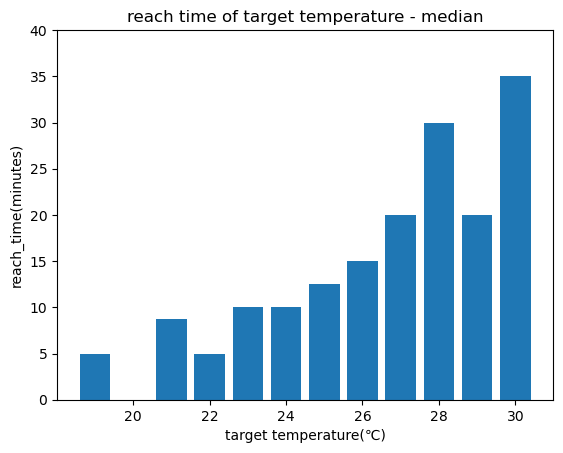

In [10]:
# 도달시간 체크 - 중앙값
plt.bar(dev_reach_time.groupby('airstate.tempstate.target')['reach_time'].median().index,dev_reach_time.groupby('airstate.tempstate.target')['reach_time'].median())
plt.title('reach time of target temperature - median')
plt.xlabel('target temperature(℃)')
plt.ylabel('reach_time(minutes)')
plt.ylim(0,40)
plt.show()

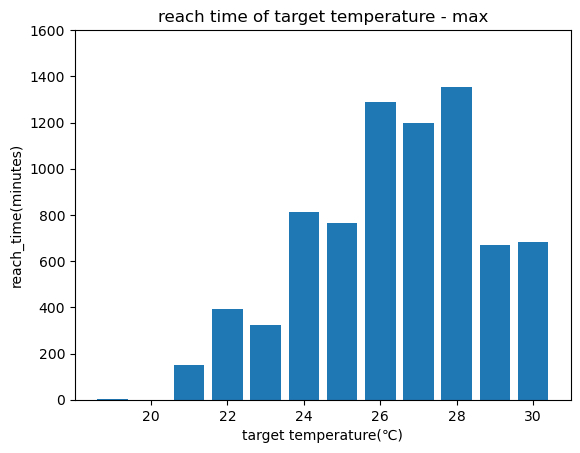

In [11]:
# 도달시간 체크 - 최대
plt.bar(dev_reach_time.groupby('airstate.tempstate.target')['reach_time'].max().index,dev_reach_time.groupby('airstate.tempstate.target')['reach_time'].max())
plt.title('reach time of target temperature - max')
plt.xlabel('target temperature(℃)')
plt.ylabel('reach_time(minutes)')
plt.ylim(0,1600)
plt.show()

In [12]:
dev_reach_time2 = dev_reach_time.groupby(['airstate.tempstate.target','start_current'])['reach_time'].agg(['size','mean','median','std', 'min','max','skew'])
dev_reach_time2 = dev_reach_time2.reset_index(drop=False)

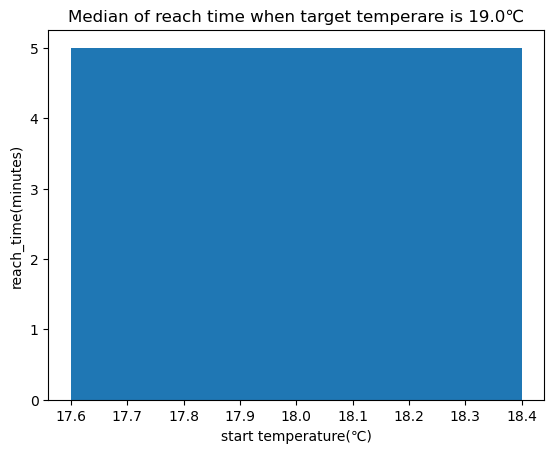

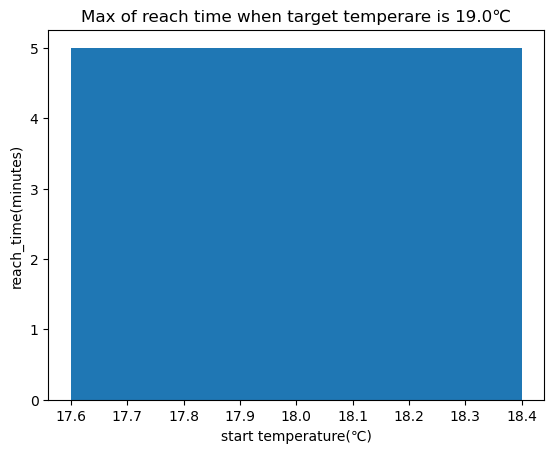

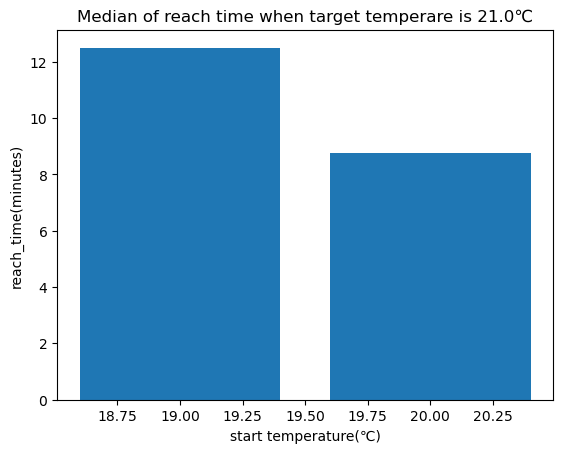

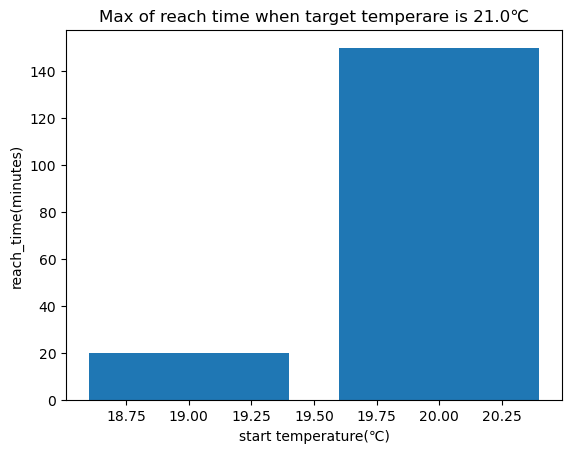

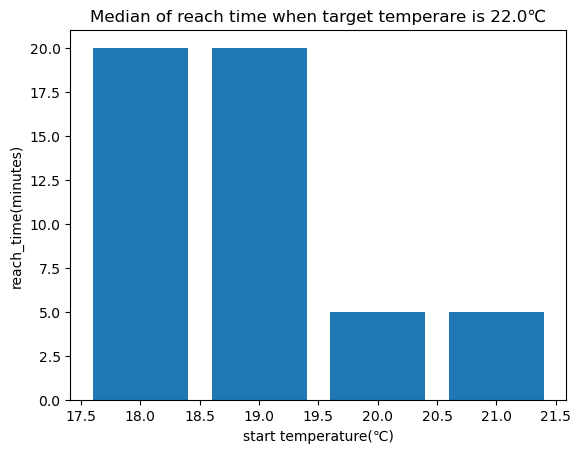

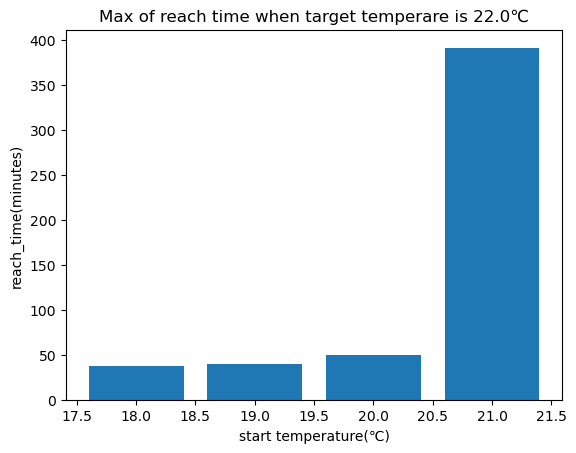

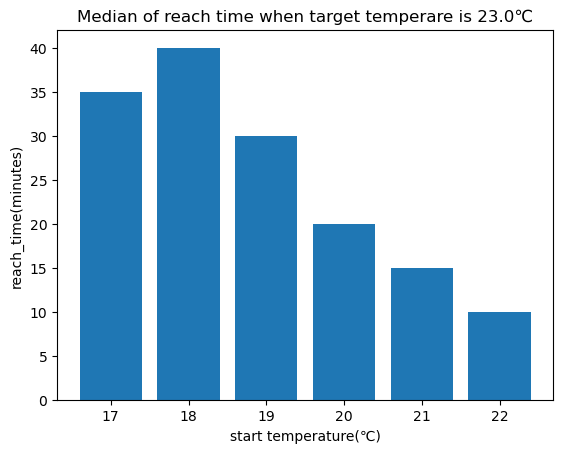

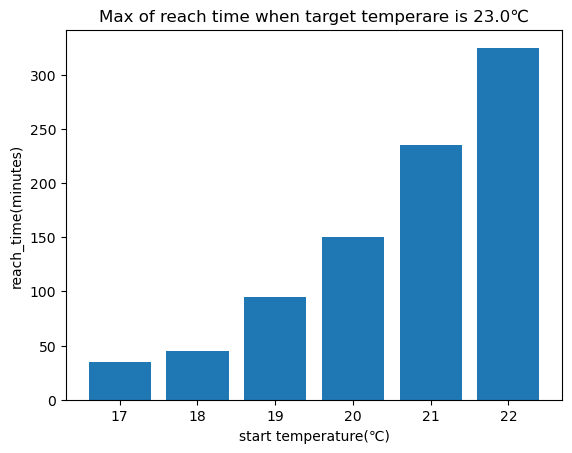

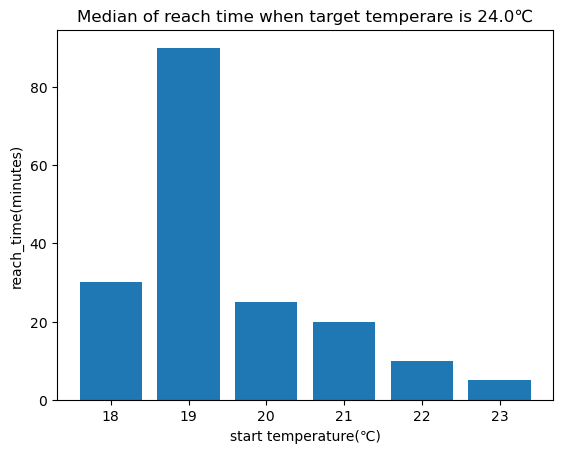

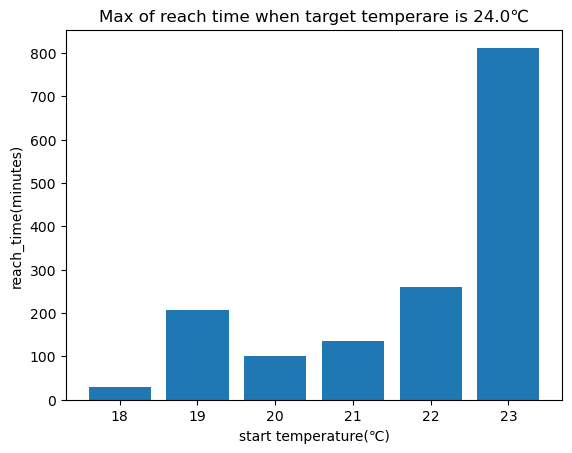

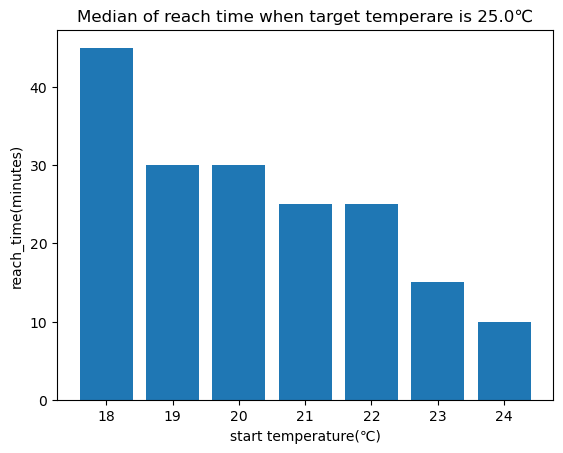

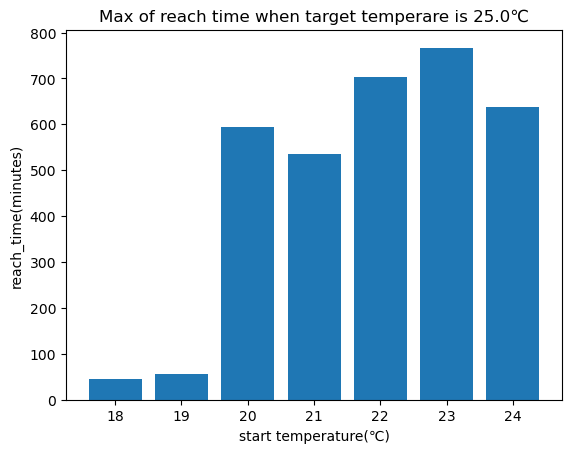

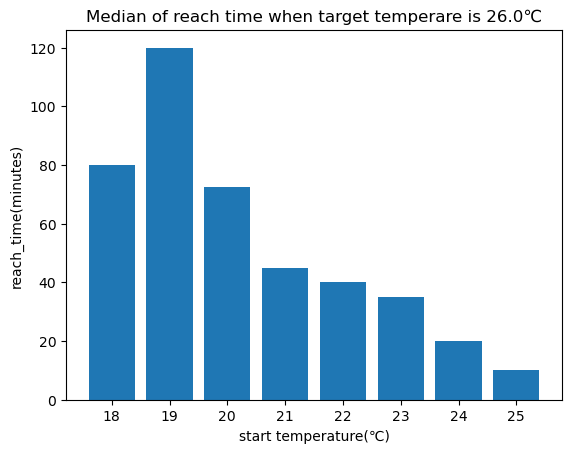

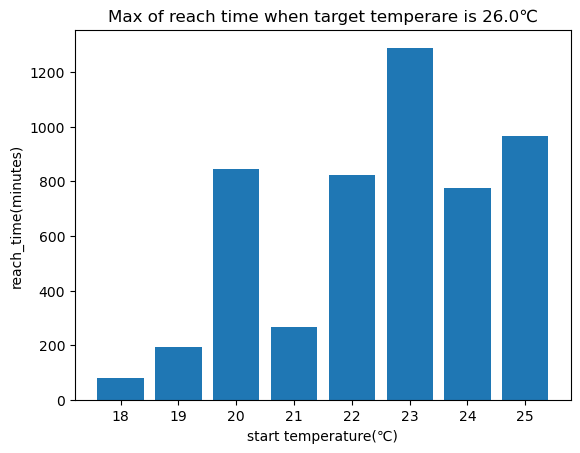

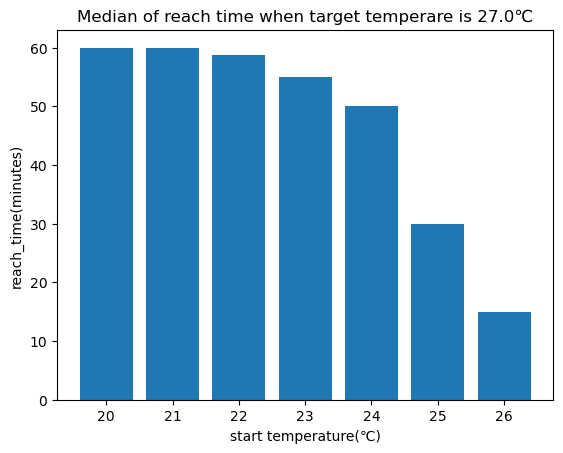

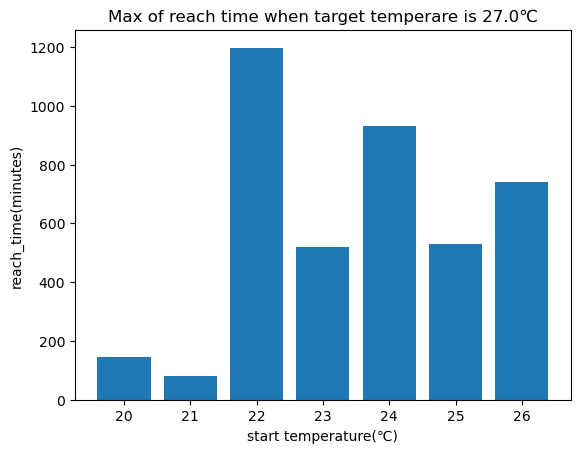

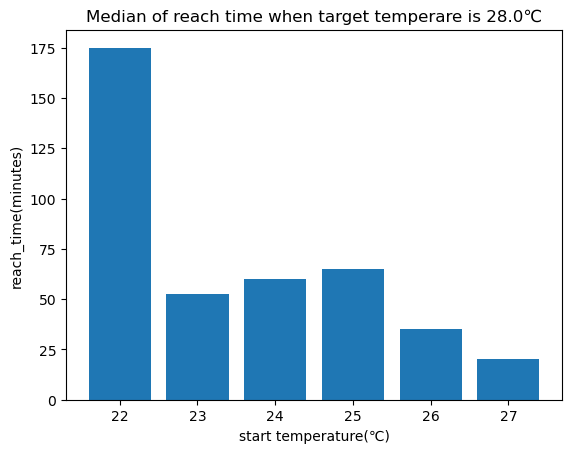

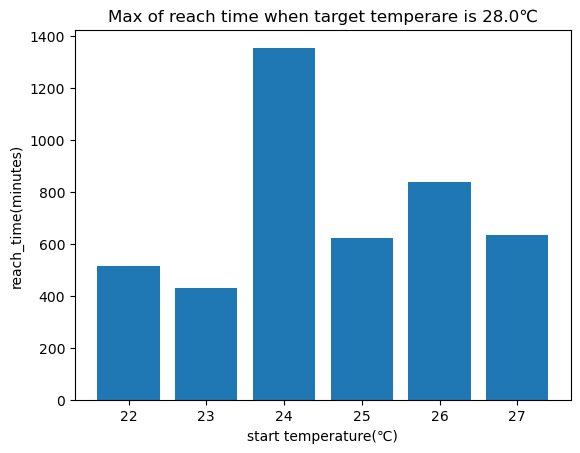

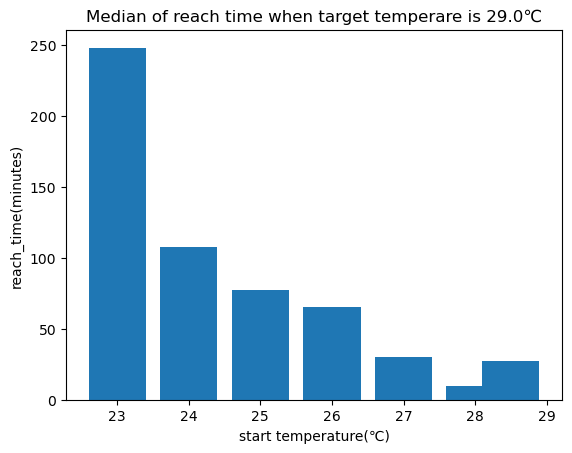

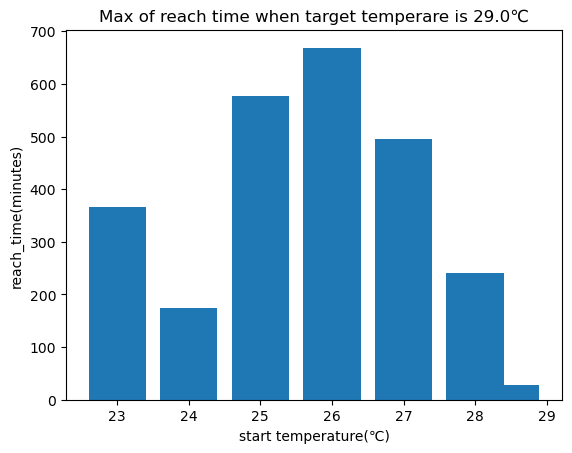

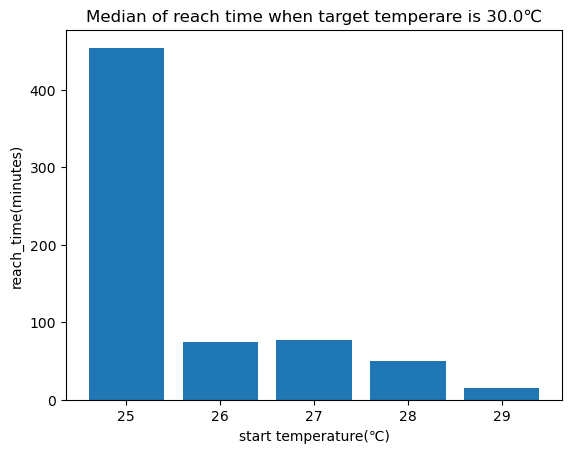

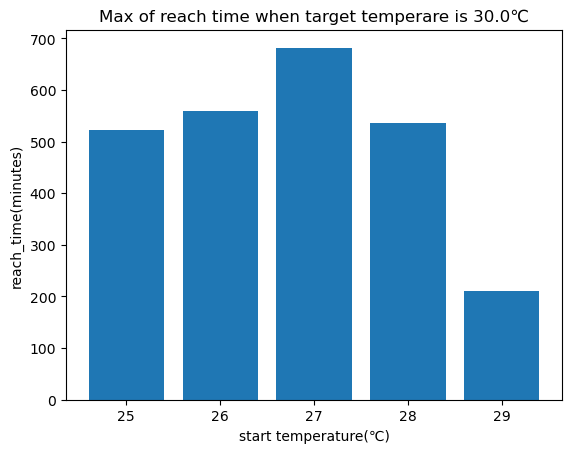

In [13]:
target=dev_reach_time2['airstate.tempstate.target'].unique()

for t in target:
    temp=dev_reach_time2.loc[dev_reach_time2['airstate.tempstate.target']==t]
    plt.bar(temp['start_current'],temp['median'])
    plt.xlabel('start temperature(℃)')
    plt.ylabel('reach_time(minutes)')
    plt.title(f'Median of reach time when target temperare is {t}℃')
    plt.show()

    plt.bar(temp['start_current'],temp['max'])
    plt.xlabel('start temperature(℃)')
    plt.ylabel('reach_time(minutes)')
    plt.title(f'Max of reach time when target temperare is {t}℃')
    plt.show()

In [17]:
cooling= dev_reach_time.loc[dev_reach_time['airstate.opmode']==1]
# 0.5도 차이 나는 건 제거
cooling.drop(cooling.loc[cooling['diff_temp']==0.5].index,inplace=True)

/tmp/ipykernel_22535/3103098324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cooling.drop(cooling.loc[cooling['diff_temp']==0.5].index,inplace=True)


In [18]:
dehum = dev_reach_time.loc[dev_reach_time['airstate.opmode']==0]

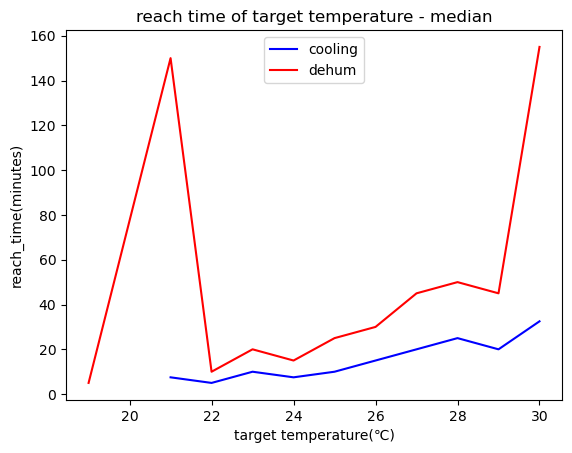

In [19]:
# 도달시간 체크 - 중앙값
plt.plot(cooling.groupby('airstate.tempstate.target')['reach_time'].median().index,cooling.groupby('airstate.tempstate.target')['reach_time'].median(),label='cooling',color='b')

plt.plot(dehum.groupby('airstate.tempstate.target')['reach_time'].median().index,dehum.groupby('airstate.tempstate.target')['reach_time'].median(),label='dehum',color='r')
plt.title('reach time of target temperature - median')
plt.xlabel('target temperature(℃)')
# plt.xlim(21,29)
# plt.ylim(5,30)
plt.ylabel('reach_time(minutes)')
plt.legend()
# plt.ylim(0,30)
plt.show()

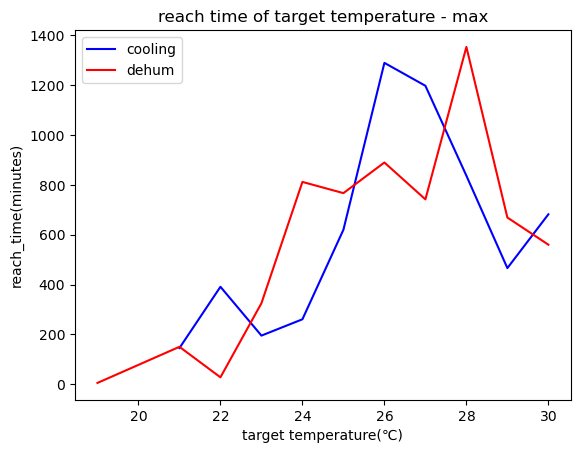

In [20]:
# 도달시간 체크 - 최대
plt.plot(cooling.groupby('airstate.tempstate.target')['reach_time'].max().index,cooling.groupby('airstate.tempstate.target')['reach_time'].max(),label='cooling',color='b')

plt.plot(dehum.groupby('airstate.tempstate.target')['reach_time'].max().index,dehum.groupby('airstate.tempstate.target')['reach_time'].max(),label='dehum',color='r')
plt.title('reach time of target temperature - max')
plt.xlabel('target temperature(℃)')
plt.ylabel('reach_time(minutes)')
plt.legend()
# plt.ylim(0,30)
plt.show()

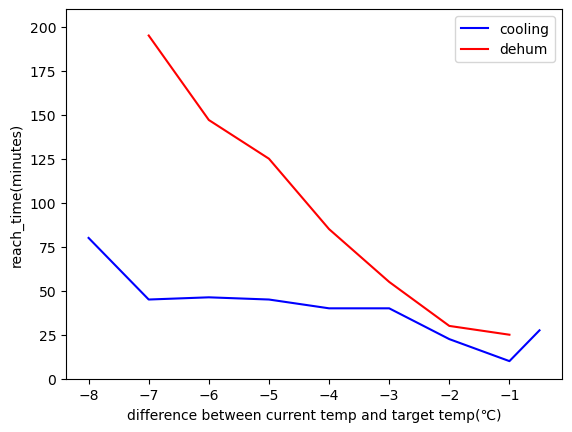

In [23]:
plt.plot(cooling.groupby('diff_temp')['reach_time'].median(),color='b',label='cooling')
plt.plot(dehum.groupby('diff_temp')['reach_time'].median(),color='r',label='dehum')
plt.ylim(0,210)
plt.ylabel('reach_time(minutes)')
plt.xlabel('difference between current temp and target temp(℃)')
plt.legend()
plt.show()

In [24]:
cal_df_wind = cal_df.loc[cal_df['average_windstrength']>0]

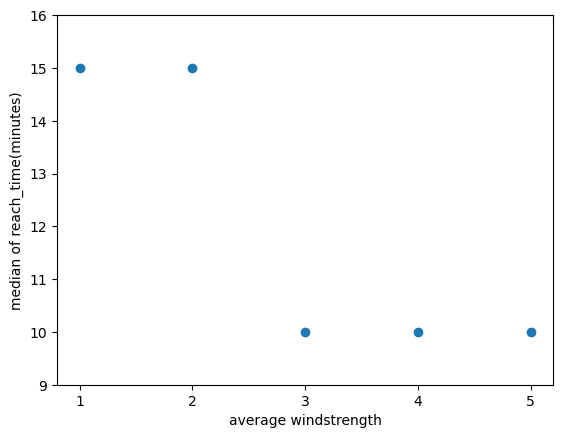

In [25]:
plt.scatter([1,2,3,4,5],cal_df_wind.groupby('average_windstrength')['reach_time'].median())
plt.ylim(9,16)
plt.xticks([1,2,3,4,5])
plt.xlabel('average windstrength')
plt.ylabel('median of reach_time(minutes)')
plt.show()

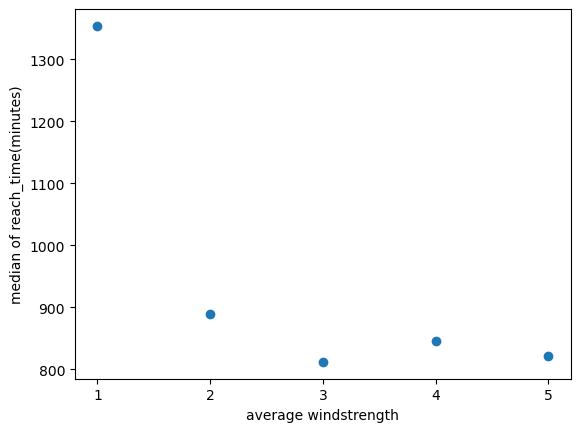

In [26]:
plt.scatter([1,2,3,4,5],cal_df_wind.groupby('average_windstrength')['reach_time'].max())
# plt.ylim(9,16)
plt.xticks([1,2,3,4,5])
plt.xlabel('average windstrength')
plt.ylabel('median of reach_time(minutes)')
plt.show()

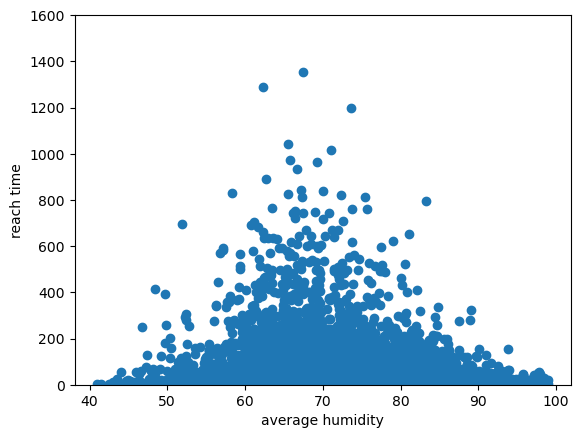

In [27]:
plt.scatter(cal_df['average_humidity'],cal_df['reach_time'])
plt.xlabel('average humidity')
plt.ylabel('reach time')
plt.ylim(0,1600)
plt.show()

In [28]:
cal_df.corr()

/tmp/ipykernel_22535/556492302.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cal_df.corr()


,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,airstate.opmode2,prior_airstate.tempstate.target,start_point,start_target,reach_time,start_current,average_humidity,average_windstrength
airstate.opmode,1.000000,0.010425,0.001478,0.142134,0.018336,0.018336,-1.000000,0.018336,NaN,0.018336,-0.219499,0.056330,0.006299,0.143397
energywatt,0.010425,1.000000,-0.156426,0.058471,-0.143241,-0.143241,-0.010425,-0.143241,NaN,-0.143241,-0.090460,-0.093503,-0.188151,0.059549
humidity,0.001478,-0.156426,1.000000,-0.000748,-0.075720,-0.075720,-0.001478,-0.075720,NaN,-0.075720,0.000103,-0.149742,0.950436,-0.002203
airstate.windstrength,0.142134,0.058471,-0.000748,1.000000,0.033104,0.033104,-0.142134,0.033104,NaN,0.033104,-0.068501,0.004193,0.014708,0.991893
currenttemperature,0.018336,-0.143241,-0.075720,0.033104,1.000000,1.000000,-0.018336,1.000000,NaN,1.000000,0.122448,0.897961,-0.009355,0.032594
airstate.tempstate.target,0.018336,-0.143241,-0.075720,0.033104,1.000000,1.000000,-0.018336,1.000000,NaN,1.000000,0.122448,0.897961,-0.009355,0.032594
airstate.opmode2,-1.000000,-0.010425,-0.001478,-0.142134,-0.018336,-0.018336,1.000000,-0.018336,NaN,-0.018336,0.219499,-0.056330,-0.006299,-0.143397
prior_airstate.tempstate.target,0.018336,-0.143241,-0.075720,0.033104,1.000000,1.000000,-0.018336,1.000000,NaN,1.000000,0.122448,0.897961,-0.009355,0.032594
start_point,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
start_target,0.018336,-0.143241,-0.075720,0.033104,1.000000,1.000000,-0.018336,1.000000,NaN,1.000000,0.122448,0.897961,-0.009355,0.032594


In [6]:
df=dev_lst[0]
df = df.reset_index(drop=True)

In [7]:
df['create_dt'] = pd.to_datetime(df['create_dt'])

In [8]:
df['prior_airstate.tempstate.target'] = df['airstate.tempstate.target'].shift(1)
df['start_point'] = 0 # 도달시간 체크 시작점
df['start_target'] = 0 # 시작시점의 타겟온도
df['reach_time'] = 0
df['start_current'] = 0 # 시작시점의 현재온도
df['prior_create_dt'] = df['create_dt'].shift(1) # 에어컨의 온오프 체크하기 위해

In [9]:
idx=df.loc[(df['airstate.tempstate.target']<df['currenttemperature'])&(df['airstate.tempstate.target']!=df['prior_airstate.tempstate.target']),:].index
df.loc[idx,'start_point'] = 1

In [10]:
# idx = df.loc[df['airstate.tempstate.target']==df['currenttemperature']].index
# df.loc[idx,'arrival_index'] = 3

In [11]:
start_point = df.loc[df['start_point']==1].index
start_point

Int64Index([  12,   43,   96,   97,  104,  110,  295,  305,  358,  444,  552,
             626,  874,  964,  991, 1164, 1178, 1258, 1355, 1472, 1760, 2147],
           dtype='int64')

In [16]:
int((df.loc[2,'create_dt']-df.loc[2,'prior_create_dt']).seconds/60)

5

In [164]:
for sp in tqdm(start_point):
    target_temp = df.loc[sp,'airstate.tempstate.target']
    start_time =  df.loc[sp,'create_dt']
    start_temp = df.loc[sp,'currenttemperature']
    for i in range(sp+1,len(df)):
        temp=df.loc[i,:]
        if temp['airstate.tempstate.target'] != target_temp : # 중간에 타겟온도 바꾸면 도달시간 체크 안함
            break
        if temp['currenttemperature'] == target_temp: # 도달시간 체크 조건
            df.loc[i,'reach_time']= int((temp['create_dt']-start_time).seconds/60)
            df.loc[i,'start_target'] = target_temp
            df.loc[i,'start_current'] = start_temp
            df.loc[sp,'start_point'] = 2
            break

100%|██████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 846.77it/s]


In [171]:
save_temp = df.loc[df['reach_time'] > 0]

,device_id_deidentification,create_dt,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,pm1,pm2,pm10,airstate.opmode2,id,arrival_index,prior_airstate.tempstate.target,start_point,start_target,reach_time,start_current
13,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 10:13:14,1,52,76.0,1,28.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,28.0,0,28,5,29
44,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 12:48:47,1,0,76.0,3,28.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,28.0,0,28,5,29
100,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 17:29:47,1,178,63.0,3,26.0,26.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,26.0,0,26,15,29
105,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 17:54:53,1,0,69.0,1,27.0,27.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,27.0,0,27,5,28
112,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 18:30:00,1,0,64.0,1,26.0,26.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,26.0,0,26,10,27
296,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 09:56:25,1,0,75.0,1,28.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,28.0,0,28,5,29
306,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 10:46:36,1,0,76.0,1,28.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,28.0,0,28,5,29
359,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 15:12:32,1,0,70.0,1,27.0,27.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,27.0,0,27,5,28
445,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 22:24:04,1,0,71.0,1,27.0,27.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,27.0,0,27,5,28
553,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-14 07:26:00,1,32,73.0,1,28.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,3,28.0,0,28,5,29


In [169]:
len(start_point)

22

In [168]:
df.loc[(df['airstate.tempstate.target']<df['currenttemperature'])&(df['airstate.tempstate.target']!=df['prior_airstate.tempstate.target']),:]

,device_id_deidentification,create_dt,airstate.opmode,energywatt,humidity,airstate.windstrength,currenttemperature,airstate.tempstate.target,pm1,pm2,pm10,airstate.opmode2,id,arrival_index,prior_airstate.tempstate.target,start_point,start_target,reach_time,start_current
12,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 10:08:13,1,0,81.0,3,29.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,29.0,1,0,0,0
43,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 12:43:46,1,41,78.0,3,29.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,29.0,1,0,0,0
96,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 17:09:43,1,0,73.0,1,29.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,30.0,1,0,0,0
97,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 17:14:44,1,66,71.0,1,29.0,26.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,28.0,1,0,0,0
104,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 17:49:52,1,0,72.0,1,28.0,27.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,28.0,1,0,0,0
110,2021071500e4b1285eeb371b87971370a1b74d7473642f...,2021-07-15 18:19:58,1,0,68.0,1,27.0,26.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,27.0,1,0,0,0
295,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 09:51:24,1,8,78.0,1,29.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,29.0,1,0,0,0
305,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 10:41:35,1,0,78.0,1,29.0,28.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,29.0,1,0,0,0
358,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 15:07:31,1,0,75.0,1,28.0,27.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,28.0,1,0,0,0
444,2021071300e4b1285eeb371b87971370a1b74d7473642f...,2021-07-13 22:19:03,1,0,76.0,1,28.0,27.0,0.0,0.0,0.0,0,00e4b1285eeb371b87971370a1b74d7473642f4faed876...,1,28.0,1,0,0,0


In [51]:
print(df['airstate.tempstate.target'].unique())

[29. 28. 30. 26. 27.]


In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2283 entries, 0 to 2282
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   device_id_deidentification       2283 non-null   object 
 1   create_dt                        2283 non-null   object 
 2   airstate.opmode                  2283 non-null   int64  
 3   energywatt                       2283 non-null   int64  
 4   humidity                         2283 non-null   float64
 5   airstate.windstrength            2283 non-null   object 
 6   currenttemperature               2283 non-null   float64
 7   airstate.tempstate.target        2283 non-null   float64
 8   pm1                              2283 non-null   float64
 9   pm2                              2283 non-null   float64
 10  pm10                             2283 non-null   float64
 11  airstate.opmode2                 2283 non-null   int64  
 12  id                  